# Testing Notebook for function fitting

## Importing Required Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from polyKAN import KANLayer
import torch
import torch.nn as nn
import torch.optim as optim

### Create dataset

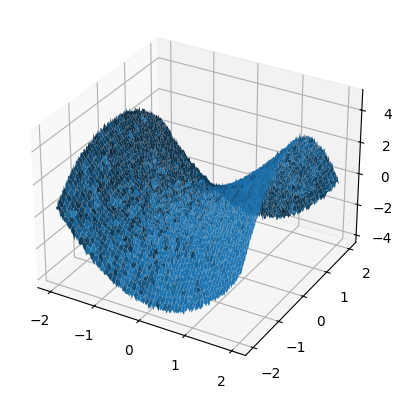

In [2]:
x1 = np.linspace(-2, 2, 200)
x2 = np.linspace(-2, 2, 200)
# create a grid of x1 and x2
X1, X2 = np.meshgrid(x1, x2)

# define the function
def func(x1, x2):
    z = np.sin(x1) * np.cos(x2) + x1**2 - x2**2
    # Add noise to z
    np.random.seed(0)
    noise = np.random.normal(0, 0.1, z.shape)
    z += noise
    return z

# call the function
Y = func(X1, X2)

# plot the function
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X1, X2, Y)
plt.show()



### Data Preprocessing

In [3]:
# create a dataset using x1 and x2 and the function
X = np.stack((X1.ravel(), X2.ravel()), axis=1)
Y = func(X1, X2).ravel()
print(X.shape, Y.shape)

(40000, 2) (40000,)


In [4]:
# training dataset is 80% of the data and the test dataset is 20% and use random points
n = X.shape[0]
n_train = int(0.8 * n)
n_test = n - n_train

# shuffle the data
np.random.seed(0)
indices = np.random.permutation(n)
X = X[indices]
Y = Y[indices]

X_train = X[:n_train]
Y_train = Y[:n_train]

X_test = X[n_train:]
Y_test = Y[n_train:]

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_dataset = torch.utils.data.TensorDataset(
    torch.tensor(X_train, dtype=torch.float32), 
    torch.tensor(Y_train, dtype=torch.float32).unsqueeze(1)  # Add this to match loss function
)
test_dataset = torch.utils.data.TensorDataset(
    torch.tensor(X_test, dtype=torch.float32), 
    torch.tensor(Y_test, dtype=torch.float32).unsqueeze(1)
)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

## Creating Multiple Poly Models

In [6]:
# define the model

class PolyNet(nn.Module):
    def __init__(self,poly_type):
        super(PolyNet, self).__init__()
        self.polynet = poly_type
        self.layer1 = KANLayer(2, 8,4,self.polynet,3,3)
        self.layer2 = KANLayer(8, 16,4,self.polynet,3,3)
        self.layer3 = KANLayer(16, 1,4,self.polynet,3,3)



    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x
    

# create MLP model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.mlp(x)

In [7]:
# make 'chebyshev', 'bessel', 'fibonacci', 'gegenbauer', 'hermite', 'jacobi', 'laguerre', and 'legendre' models

chebyshev_model = PolyNet('chebyshev')
bessel_model = PolyNet('bessel')
fibonacci_model = PolyNet('fibonacci')
gegenbauer_model = PolyNet('gegenbauer')
hermite_model = PolyNet('hermite')
jacobi_model = PolyNet('jacobi')
laguerre_model = PolyNet('laguerre')
legendre_model = PolyNet('legendre')

In [8]:

chebyshev_model.to(device)
bessel_model.to(device)
fibonacci_model.to(device)
gegenbauer_model.to(device)
hermite_model.to(device)
jacobi_model.to(device)
laguerre_model.to(device)
legendre_model.to(device)

chebyshev_model_params = sum(p.numel() for p in chebyshev_model.parameters() if p.requires_grad)
bessel_model_params = sum(p.numel() for p in bessel_model.parameters() if p.requires_grad)
fibonacci_model_params = sum(p.numel() for p in fibonacci_model.parameters() if p.requires_grad)
gegenbauer_model_params = sum(p.numel() for p in gegenbauer_model.parameters() if p.requires_grad)
hermite_model_params = sum(p.numel() for p in hermite_model.parameters() if p.requires_grad)
jacobi_model_params = sum(p.numel() for p in jacobi_model.parameters() if p.requires_grad)
laguerre_model_params = sum(p.numel() for p in laguerre_model.parameters() if p.requires_grad)
legendre_model_params = sum(p.numel() for p in legendre_model.parameters() if p.requires_grad)

print(f"Chebyshev model trainable parameters: {chebyshev_model_params}")
print(f"Bessel model trainable parameters: {bessel_model_params}")
print(f"Fibonacci model trainable parameters: {fibonacci_model_params}")
print(f"Gegenbauer model trainable parameters: {gegenbauer_model_params}")
print(f"Hermite model trainable parameters: {hermite_model_params}")
print(f"Jacobi model trainable parameters: {jacobi_model_params}")
print(f"Laguerre model trainable parameters: {laguerre_model_params}")
print(f"Legendre model trainable parameters: {legendre_model_params}")

Chebyshev model trainable parameters: 800
Bessel model trainable parameters: 800
Fibonacci model trainable parameters: 800
Gegenbauer model trainable parameters: 800
Hermite model trainable parameters: 800
Jacobi model trainable parameters: 800
Laguerre model trainable parameters: 800
Legendre model trainable parameters: 800


## Training The Models

In [9]:

def train_model(model, train_loader, test_loader, epochs):
    train_losses = []
    test_losses = []
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=50, factor=0.5)
    criterion = nn.MSELoss()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    print('Starting Training')
    print(f'==============={model.polynet}================')
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Add gradient clipping
            optimizer.step()
            total_train_loss += loss.item()
        
        train_loss = total_train_loss / len(train_loader)
        train_losses.append(train_loss)
        
        model.eval()
        total_test_loss = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                total_test_loss += loss.item()
        
        test_loss = total_test_loss / len(test_loader)
        test_losses.append(test_loss)
        
        scheduler.step(test_loss)  # Step the learning rate scheduler
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
    
    print('Finished Training')
    print(f'Epoch {epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
    
    return train_losses, test_losses


epochs = 100

chebyshev_train_losses, chebyshev_test_losses = train_model(chebyshev_model,train_loader,test_loader,epochs)
bessel_train_losses, bessel_test_losses = train_model(bessel_model,train_loader,test_loader,epochs)
fibonacci_train_losses, fibonacci_test_losses = train_model(fibonacci_model,train_loader,test_loader,epochs)
gegenbauer_train_losses, gegenbauer_test_losses = train_model(gegenbauer_model,train_loader,test_loader,epochs)
hermite_train_losses, hermite_test_losses = train_model(hermite_model,train_loader,test_loader,epochs)
jacobi_train_losses, jacobi_test_losses = train_model(jacobi_model,train_loader,test_loader,epochs)
laguerre_train_losses, laguerre_test_losses = train_model(laguerre_model,train_loader,test_loader,epochs)
legendre_train_losses, legendre_test_losses = train_model(legendre_model,train_loader,test_loader,epochs)


Starting Training
===============chebyshev================
Epoch 1, Train Loss: 2.1199, Test Loss: 0.5284
Epoch 11, Train Loss: 0.0126, Test Loss: 0.0125
Epoch 21, Train Loss: 0.0113, Test Loss: 0.0110
Epoch 31, Train Loss: 0.0107, Test Loss: 0.0111
Epoch 41, Train Loss: 0.0105, Test Loss: 0.0112
Epoch 51, Train Loss: 0.0104, Test Loss: 0.0104
Epoch 61, Train Loss: 0.0106, Test Loss: 0.0112
Epoch 71, Train Loss: 0.0104, Test Loss: 0.0106
Epoch 81, Train Loss: 0.0104, Test Loss: 0.0113
Epoch 91, Train Loss: 0.0104, Test Loss: 0.0106
Finished Training
Epoch 100, Train Loss: 0.0104, Test Loss: 0.0105
Starting Training
===============bessel================
Epoch 1, Train Loss: 1.6659, Test Loss: 0.7952
Epoch 11, Train Loss: 0.1639, Test Loss: 0.1453
Epoch 21, Train Loss: 0.1422, Test Loss: 0.1506
Epoch 31, Train Loss: 0.0970, Test Loss: 0.0922
Epoch 41, Train Loss: 0.1263, Test Loss: 0.2119
Epoch 51, Train Loss: 0.1167, Test Loss: 0.2120
Epoch 61, Train Loss: 0.1140, Test Loss: 0.1384
Epoc

### Plotting The Results

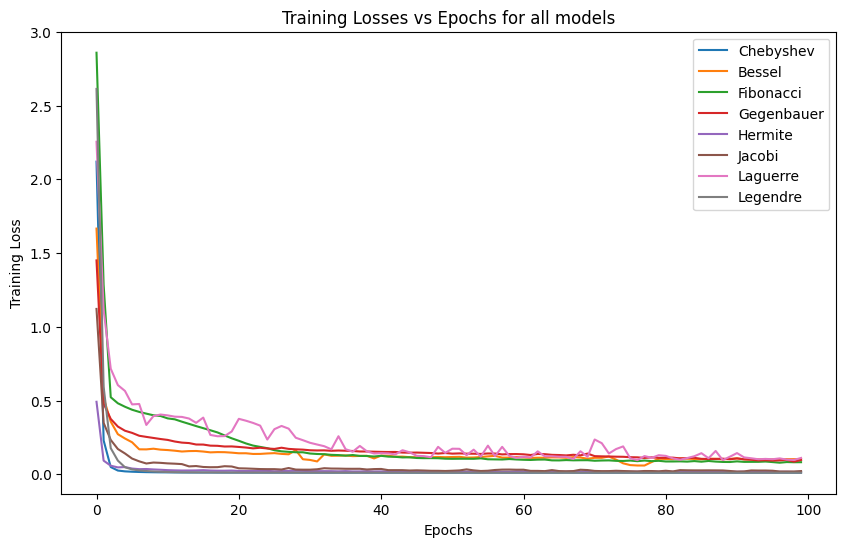

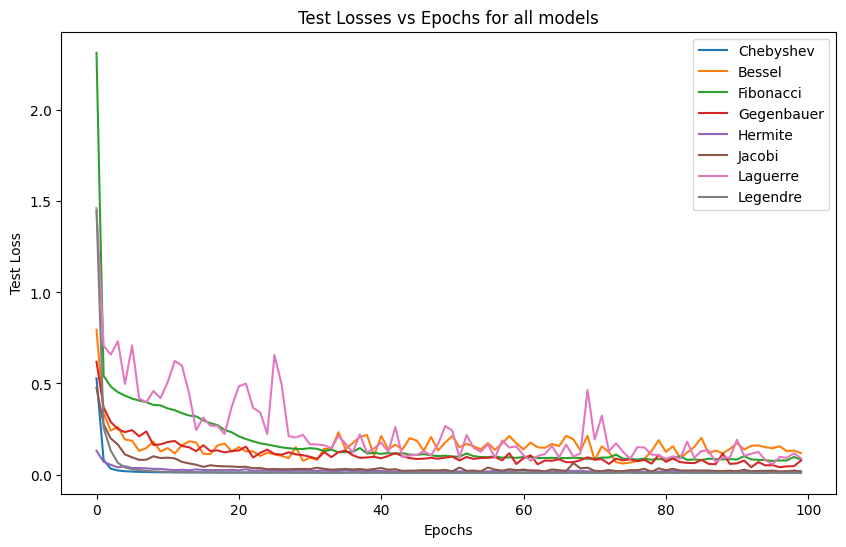

In [10]:
# plot the training losses against epochs for all models
plt.figure(figsize=(10, 6))
plt.plot(chebyshev_train_losses, label='Chebyshev')
plt.plot(bessel_train_losses, label='Bessel')
plt.plot(fibonacci_train_losses, label='Fibonacci')
plt.plot(gegenbauer_train_losses, label='Gegenbauer')
plt.plot(hermite_train_losses, label='Hermite')
plt.plot(jacobi_train_losses, label='Jacobi')
plt.plot(laguerre_train_losses, label='Laguerre')
plt.plot(legendre_train_losses, label='Legendre')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.legend()
plt.title('Training Losses vs Epochs for all models')
plt.show()

# plot the test losses against epochs for all models
plt.figure(figsize=(10, 6))
plt.plot(chebyshev_test_losses, label='Chebyshev')
plt.plot(bessel_test_losses, label='Bessel')
plt.plot(fibonacci_test_losses, label='Fibonacci')
plt.plot(gegenbauer_test_losses, label='Gegenbauer')
plt.plot(hermite_test_losses, label='Hermite')
plt.plot(jacobi_test_losses, label='Jacobi')
plt.plot(laguerre_test_losses, label='Laguerre')
plt.plot(legendre_test_losses, label='Legendre')
plt.xlabel('Epochs')
plt.ylabel('Test Loss')
plt.legend()
plt.title('Test Losses vs Epochs for all models')
plt.show()